# WandB Dataset Visualization Demo
This notebook demostrates WandB's dataset visualization features. In particular we will show how WandB Artifacts can be used to visualize datasets and predictions, specifically on image data and mask predictions. Further we will use this tool to analyze our model and make a decision about how to move forward with our modeling efforts. We will:
1. Create a dataset
2. Train a model to make predictions on the transformed dataet
3. Log predications from the model against training and evaluation sets
4. Analyze the model in WandB's UI

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
!pip install pandas matplotlib opencv-python ipywidgets numpy wandb > /dev/null
!pip install -e ~/workspace/wandb-client > /dev/null

You are using pip version 19.0.3, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import os
os.environ["WANDB_BASE_URL"] = "http://api.wandb.test"
WANDB_PROJECT = "dv_demo_big"
import matplotlib.pyplot as plt
import cv2 # opencv-python
import numpy as np
import wandb

## Create a Dataset
In this step, we will download an example dataset and save it to WandB

In [5]:
# Download the data if not already


![ ! -f bdd100k.tgz ] && curl https://storage.googleapis.com/l2kzone/bdd100k.tgz --output bdd100k.tgz
![ ! -d bdd100k ] && tar xzf bdd100k.tgz

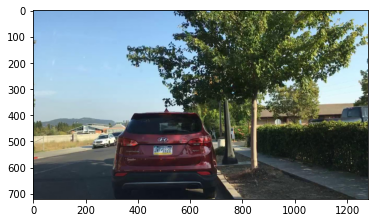

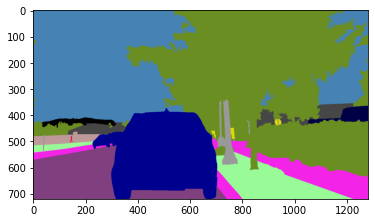

In [6]:
# Setup some basic utilities for working with this data


BDD_CLASSES = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
BDD_IDS = list(range(len(BDD_CLASSES) - 1)) + [255]
BDD_ID_MAP = {
    id:ndx
    for ndx, id in enumerate(BDD_IDS)
}

n_classes = len(BDD_CLASSES)
bdd_dir = os.path.join('.', 'bdd100k', 'seg')
train_dir = os.path.join(bdd_dir, 'images', 'train')
color_labels_dir = os.path.join(bdd_dir, 'color_labels', 'train')
labels_dir = os.path.join(bdd_dir, 'labels', 'train')

train_ids = [name.split(".")[0] for name in os.listdir(train_dir)]

def show_image(path):
    plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
    plt.show()
    
def get_train_image_path(ndx):
    return os.path.join(train_dir, train_ids[ndx] + ".jpg")

def get_color_label_image_path(ndx):
    return os.path.join(color_labels_dir, train_ids[ndx] + "_train_color.png")

def get_label_image_path(ndx):
    return os.path.join(labels_dir, train_ids[ndx] + "_train_id.png")

def get_dominant_id_ndx(np_image):
    if isinstance(np_image, wandb.Image):
        np_image = np.array(np_image._image)
    return BDD_ID_MAP[np.argmax(np.bincount(np_image.astype(int).flatten()))]

# Show an example training image
show_image(get_train_image_path(0))

# Show an example training image
show_image(get_color_label_image_path(0))

In [7]:
# First, we will build our dataset for later use. We will do this in a WandB Run.
# Note, this (and all other runs) can be performed at different time, machines, or environments.

NUM_EXAMPLES = 1000

with wandb.init(project=WANDB_PROJECT, job_type="create_dataset", config={
        "num_examples": NUM_EXAMPLES
    }) as run:
    config = run.config
    
    # Setup a WandB Classes object. This will give additional metadata for visuals
    class_set = wandb.Classes(
        [{'name': c, 'id': i} for i, c in enumerate(BDD_CLASSES)])
    
    # Setup a WandB Table object to hold our dataset
    table = wandb.Table(["id", "train_image", "colored_image", "label_mask", "dominant_class"])
    
    # Fill up the table
    for ndx in range(config["num_examples"]):
        example = wandb.Image(get_train_image_path(ndx), classes=class_set, masks={
            "ground_truth": {
                "path": get_label_image_path(ndx), # This will generate a nice overlay in the UI
            },
        })
        color_label = wandb.Image(get_color_label_image_path(ndx), classes=class_set)
        label_mask = wandb.Image(get_label_image_path(ndx), classes=class_set)
        table.add_data(train_ids[ndx], example, color_label, label_mask, BDD_CLASSES[get_dominant_id_ndx(label_mask)])
    
    # Create an Artifact (versioned folder)
    artifact = wandb.Artifact(name="raw_data", type="database")
    
    # add the table to the artifact
    artifact.add(table, "raw_examples")
    
    # Finally, log the artifact
    run.log_artifact(artifact)


wandb: Currently logged in as: new-team (use `wandb login --relogin` to force relogin)


wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmpf2n5wp_x)... Done. 0.1s


wandb: Downloading large artifact raw_data:latest, 130.35MB. 3002 files... Done. 0.3s


Data row:  ['04a328c5-7d9c636f', <wandb.data_types.Image object at 0x14aa6c208>, <wandb.data_types.Image object at 0x14aa6c6a0>, <wandb.data_types.Image object at 0x14aa6cb00>, 'vegetation']
Artifact Directory Contents:  ['train_results:v2', 'train_results:v5', 'test_results:v3', 'test_results:v4', 'test_results:v5', 'test_results:v10', 'test_results:v2', 'train_results:v4', 'train_results:v3', 'raw_data:v0', 'raw_data:v1', 'raw_data:v6', 'test_data:v6', 'test_data:v1', 'train_data:v6', 'trained_model:v1', 'train_data:v1', 'test_data:v0', 'train_data:v0', 'trained_model:v0', 'test_results:v9', 'train_results:v6', 'train_results:v1', 'train_results:v8', 'test_results:v7', 'test_results:v0', 'test_results:v1', 'train_results:v9', 'test_results:v6', 'train_results:v0', 'test_results:v8', 'train_results:v7', 'raw_data:v3', 'raw_data:v4', 'train_results:v10', 'raw_data:v5', 'raw_data:v2', 'train_data:v2', 'train_data:v5', 'trained_model:v2', 'test_data:v2', 'test_data:v5', 'train_data:v4', 

wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmpignfsxmd)... Done. 0.1s
wandb: Adding directory to artifact (/var/folders/wv/j7nq4t9j7tl2cq_2mz2mhbj40000gn/T/tmpfdfd96jj)... Done. 0.1s


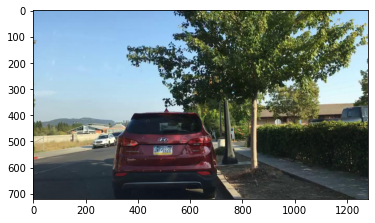

In [8]:
# Next, let's see the data and split it

with wandb.init(project=WANDB_PROJECT, job_type="split_dataset") as run:
    # Get the latest version of the artifact
    dataset_artifact = run.use_artifact("raw_data:latest")
    data_table = dataset_artifact.get("raw_examples")
    
    # Print a row
    print("Data row: ", data_table.data[0])
    
    # Show the image
    plt.imshow(data_table.data[0][1]._image)
    
    # Notice that a new directory was made: artifacts which is managed by wandb
    print("Artifact Directory Contents: ", os.listdir("artifacts"))
    
    # Now we can build two separate artifacts for later use.
    train_count = int(len(data_table.data) * .7)
    train_table = wandb.Table(columns=data_table.columns, data=data_table.data[:train_count])
    test_table = wandb.Table(columns=data_table.columns, data=data_table.data[train_count:])
    
    train_artifact = wandb.Artifact("train_data", "database")
    test_artifact = wandb.Artifact("test_data", "database")
    
    train_artifact.add(train_table, "train_table")
    test_artifact.add(test_table, "test_table")
    
    run.log_artifact(train_artifact)
    run.log_artifact(test_artifact)

In [9]:
# Next, we will train a model to predict the different regions. This tutorial is not
# focused on model training, so we will keep things simple
import numpy as np
import pickle

class ExampleSegmentationModel:
    def __init__(self, n_classes):
        self.n_classes = n_classes
        
    def train(self, images, masks):
        self.min = images.min()
        self.max = images.max()
        images = (images - self.min) / (self.max - self.min)
        step = 1.0 / n_classes
        self.quantiles = list(np.quantile(images, [i * step for i in range(self.n_classes)]))
        self.quantiles.append(1.0)
        self.outshape = masks.shape
        
    def predict(self, images):
        results = np.zeros((images.shape[0], self.outshape[1], self.outshape[2]))
        images = ((images - self.min) / (self.max - self.min)).mean(axis=3)
        for i in range(self.n_classes):
            results[(self.quantiles[i] < images) & (images <= self.quantiles[i+1])] = BDD_IDS[i]
        return results
    
    def save(self, file_path):
        with open(file_path, "wb") as file:
            pickle.dump(model, file)
    
    @staticmethod
    def load(file_path):
        model = None
        with open(file_path, "rb") as file:
            model = pickle.load(file)
        return model
    
def iou(mask_a, mask_b, class_id):
    return ((mask_a == class_id) & (mask_b == class_id)).sum(axis=(1,2)) / ((mask_a == class_id) | (mask_b == class_id)).sum(axis=(1,2))

def score_model(model, x_data, mask_data, n_classes):
    results = model.predict(x_data)
    return np.array([iou(results, mask_data, i) for i in BDD_IDS]).T, results

def make_datasets(data_table, n_classes):
    n_samples = len(data_table.data)
    n_classes = len(BDD_CLASSES)
    height = data_table.data[0][1]._image.height
    width = data_table.data[0][1]._image.width

    train_data = np.array([np.array(data_table.data[i][1]._image.getdata()).reshape(height, width, 3) for i in range(n_samples)])
    mask_data = np.array([np.array(data_table.data[i][3]._image.getdata()).reshape(height, width) for i in range(n_samples)])
    return train_data, mask_data

with wandb.init(project=WANDB_PROJECT, job_type="model_train") as run:
    train_artifact = run.use_artifact("train_data:latest")
    train_table = train_artifact.get("train_table")
    
    train_data, mask_data = make_datasets(train_table, n_classes)
    model = ExampleSegmentationModel(n_classes)
    model.train(train_data, mask_data)
    
    scores, results = score_model(model, train_data, mask_data, n_classes)
    results_artifact = wandb.Artifact("train_results", "database")
    data = [
        [train_table.data[ndx][0], 
         wandb.Image(train_table.data[ndx][1]._path, classes=class_set, masks={
            "train_predicted_truth": {
                "mask_data": results[ndx],
            },
        }),
        BDD_CLASSES[get_dominant_id_ndx(results[ndx])],
        ] + list(row)
        for ndx, row in enumerate(scores)
    ]
    results_artifact.add(wandb.Table(["id", "pred_mask", "dominant_pred"] + BDD_CLASSES, data=data), "train_iou_score_table")
    run.log_artifact(results_artifact)
    
    model.save("model.pkl")
    model_artifact = wandb.Artifact("trained_model", "model")
    model_artifact.add_file("model.pkl")
    run.log_artifact(model_artifact)
    


wandb: Downloading large artifact train_data:latest, 93.91MB. 2102 files... Done. 0.2s


KeyboardInterrupt: 

In [ ]:
## Now time to score the model

with wandb.init(project=WANDB_PROJECT, job_type="model_eval") as run:
    test_artifact = run.use_artifact("test_data:latest")
    test_table = test_artifact.get("test_table")
    test_data, mask_data = make_datasets(test_table, n_classes)
    
    model_artifact = run.use_artifact("trained_model:latest")
    path = model_artifact.get_path("model.pkl").download()
    
    model = ExampleSegmentationModel.load(path)
    scores, results = score_model(model, test_data, mask_data, n_classes)
    
    results_artifact = wandb.Artifact("test_results", "database")
    data = [
        [test_table.data[ndx][0], 
         wandb.Image(test_table.data[ndx][1]._path, classes=class_set, masks={
            "test_predicted_truth": {
                "mask_data": results[ndx],
            },
        }),
        BDD_CLASSES[get_dominant_id_ndx(results[ndx])],
        ] + list(row)
        for ndx, row in enumerate(scores)
    ]
    results_artifact.add(wandb.Table(["id", "pred_mask_test", "dominant_pred_test"] + BDD_CLASSES, data=data), "test_iou_score_table")
    run.log_artifact(results_artifact)

In [ ]:
## Finally, some analysis

with wandb.init(project=WANDB_PROJECT, job_type="model_result_analysis") as run:
    dataset_artifact = run.use_artifact("raw_data:latest")
    data_table = dataset_artifact.get("raw_examples")
    train_artifact = run.use_artifact("train_results:latest")
    train_table = train_artifact.get("train_iou_score_table")
    
    test_artifact = run.use_artifact("test_results:latest")
    test_table = test_artifact.get("test_iou_score_table")
    
    train_results = wandb.JoinedTable(train_table, data_table, "id")
    test_results = wandb.JoinedTable(test_table, data_table, "id")
    artifact = wandb.Artifact("summary_results", "database")
    artifact.add(train_results, "train_results")
    artifact.add(test_results, "test_results")
    
    run.log_artifact(artifact)
